In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision 
import torchvision.datasets as datasets 
import torchvision.transforms as transforms 
from torch.utils.data import Dataset, DataLoader 
from torch.utils.tensorboard import SummaryWriter 
from dcgan_model import Discriminator, Generator, initialise_weights
import random
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-3  # could also use two lrs, one for gen and one for disc
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
Z_DIM=100
NUM_EPOCHS = 50
FEATURES_DISC = 64
FEATURES_GEN = 64

In [3]:
transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

In [4]:
#dataset = datasets.MNIST(root= "dataset/", train=True,transform=transforms, download=True)
dataset= datasets.ImageFolder(root= 'flowers', transform=transforms)
loader =DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
gen= Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc= Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialise_weights(gen)
initialise_weights(disc)

optgen= optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5,0.999))
optdisc= optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5,0.999))
criterion= nn.BCELoss()

fixed_noise= torch.randn(32,Z_DIM, 1,1).to(device)

writer_real= SummaryWriter(f"logs_flower/real")
writer_fake= SummaryWriter(f"logs_flower/fake")

step=0
gen.train()
disc.train()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [52]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real,_) in enumerate(loader):
        real= real.to(device)
        noise= torch.randn((BATCH_SIZE,Z_DIM,1,1)).to(device)
        fake= gen(noise)

        # Train Discriminator
        disc_real= disc(real).reshape(-1)
        loss_disc_real= criterion(disc_real, torch.ones_like(disc_real))
        disc_fake= disc(fake.detach()).reshape(-1)
        loss_disc_fake= criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc= (loss_disc_fake + loss_disc_real)/2
        disc.zero_grad()
        loss_disc.backward(retain_graph=True)
        optdisc.step()

        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        optgen.step()

        if batch_idx % 50 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                  Loss D: {loss_disc:.6f}, loss G: {loss_gen:.6f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
                img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)

                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)

            step += 1

Epoch [0/50] Batch 0/128                   Loss D: 0.129678, loss G: 2.913859
Epoch [0/50] Batch 50/128                   Loss D: 0.172140, loss G: 4.635511
Epoch [0/50] Batch 100/128                   Loss D: 0.237137, loss G: 4.229208
Epoch [1/50] Batch 0/128                   Loss D: 0.866935, loss G: 7.460791
Epoch [1/50] Batch 50/128                   Loss D: 0.280682, loss G: 3.280406
Epoch [1/50] Batch 100/128                   Loss D: 0.319081, loss G: 4.053552
Epoch [2/50] Batch 0/128                   Loss D: 0.278208, loss G: 2.705907
Epoch [2/50] Batch 50/128                   Loss D: 0.186138, loss G: 4.179410
Epoch [2/50] Batch 100/128                   Loss D: 0.120817, loss G: 4.294186
Epoch [3/50] Batch 0/128                   Loss D: 0.658553, loss G: 8.426952
Epoch [3/50] Batch 50/128                   Loss D: 0.137478, loss G: 4.547496
Epoch [3/50] Batch 100/128                   Loss D: 0.235384, loss G: 4.392564
Epoch [4/50] Batch 0/128                   Loss D: 0

In [6]:
def save_model(model, optimizer, filename):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
    }, filename)

def load_model(model, optimizer, filename):
    chk= torch.load(filename)
    model.load_state_dict(chk['model_state_dict'])
    optimizer.load_state_dict(chk['optimizer_state_dict'])

In [7]:
# save_model(gen,optgen,'gen_flowers_dcgan.pth')
# save_model(disc,optdisc,'disc_flowers_dcgan.pth')

In [13]:
gen= Generator(Z_DIM,CHANNELS_IMG,FEATURES_GEN).to(device)
discrim= Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

optgen= optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5,0.999))
optdisc= optim.Adam(discrim.parameters(), lr=LEARNING_RATE, betas=(0.5,0.999))

load_model(gen,optgen, 'gen_celebs_dcgan.pth')
load_model(discrim, optdisc, 'disc_celebs_dcgan.pth')
gen.eval()
discrim.eval()

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [14]:
import matplotlib.pyplot as plt 
def show_grid(grid):
    # Assuming the grid is already normalized in the range [0, 1]
    np_grid = grid.cpu().permute(1, 2, 0).numpy()  # Move the channels to the last dimension
    plt.imshow(np_grid)
    plt.axis('off')  # Turn off axis labels
    plt.show()

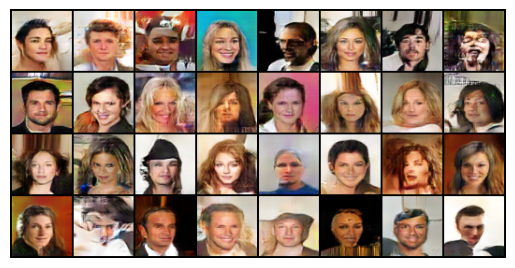

In [15]:
fixed_noise= torch.randn(32,Z_DIM, 1,1).to(device)
gen_imgs= gen(fixed_noise)
# noise_grid= torchvision.utils.make_grid(fixed_noise[:32])
img_grid_fake2 = torchvision.utils.make_grid(gen_imgs[:32], normalize=True)
show_grid(img_grid_fake2)

In [16]:
features_disc=[]
features_gen=[]

def hook_fn_disc(module, input , output):
    features_disc.append(output)

def hook_fn_gen(module,input,output):
    features_gen.append(output)

for layer in discrim.disc:
    if isinstance(layer, nn.Conv2d):
        layer.register_forward_hook(hook_fn_disc)
    if isinstance(layer, nn.Sequential):
        layer[0].register_forward_hook(hook_fn_disc)

for layer in gen.gen:
    if isinstance(layer, nn.ConvTranspose2d):
        layer.register_forward_hook(hook_fn_gen)
    if isinstance(layer, nn.Sequential):
        layer[0].register_forward_hook(hook_fn_gen)

_= discrim(gen_imgs)
_= gen(fixed_noise)

In [17]:
gen.gen

Sequential(
  (0): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): Tanh

Discriminator Layers: 

Layer Number:  0
Total Number of Features in the Layer:  64
Selected Feature Indexes:  [ 4 17 59 40 40 63 57 41 23 23 41 13 20 21 48 30]


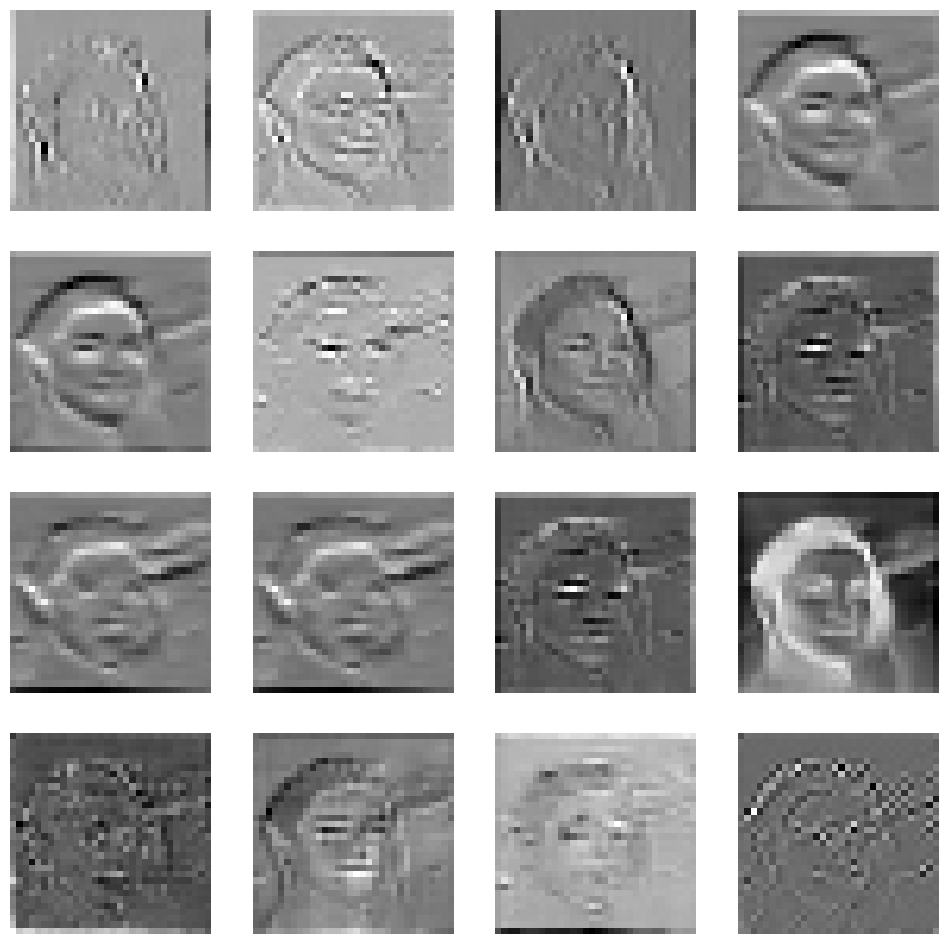


Layer Number:  1
Total Number of Features in the Layer:  128
Selected Feature Indexes:  [ 33  33  27  62  35  10 116   4  59  87  22  58  73  78  57  23]


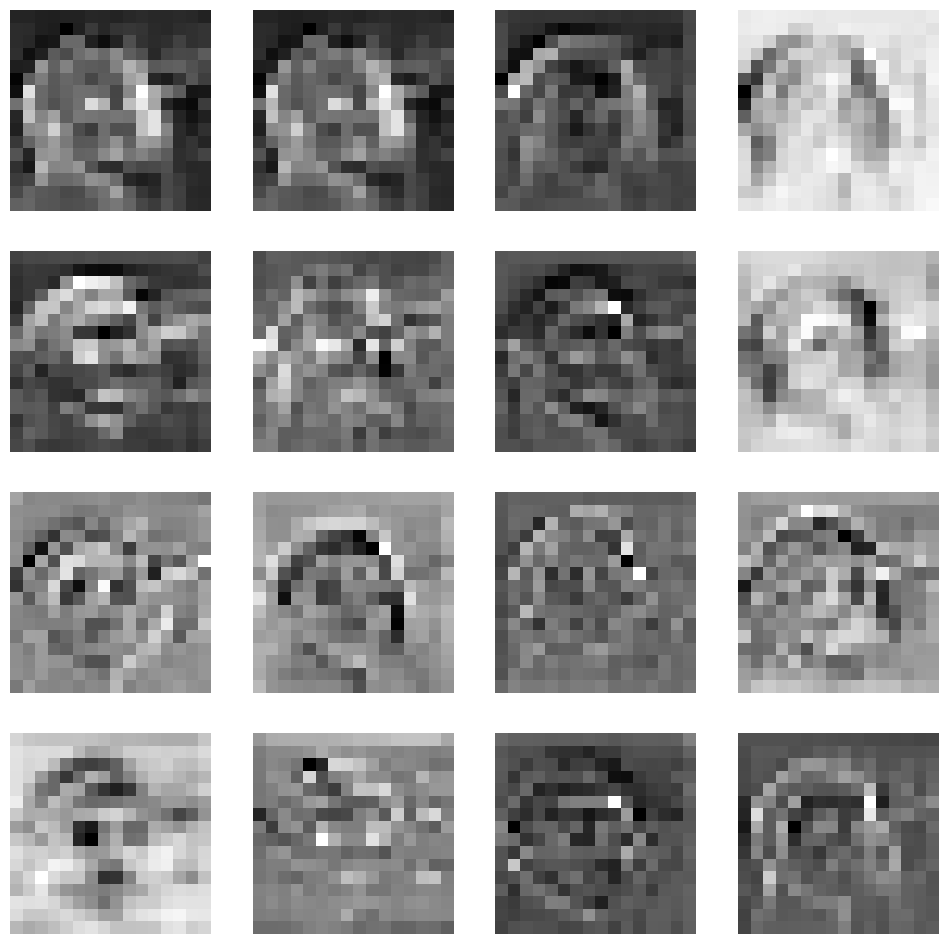


Layer Number:  2
Total Number of Features in the Layer:  256
Selected Feature Indexes:  [232 244 210 199  68 168  75  76 146 123 165 121 190 150 122  70]


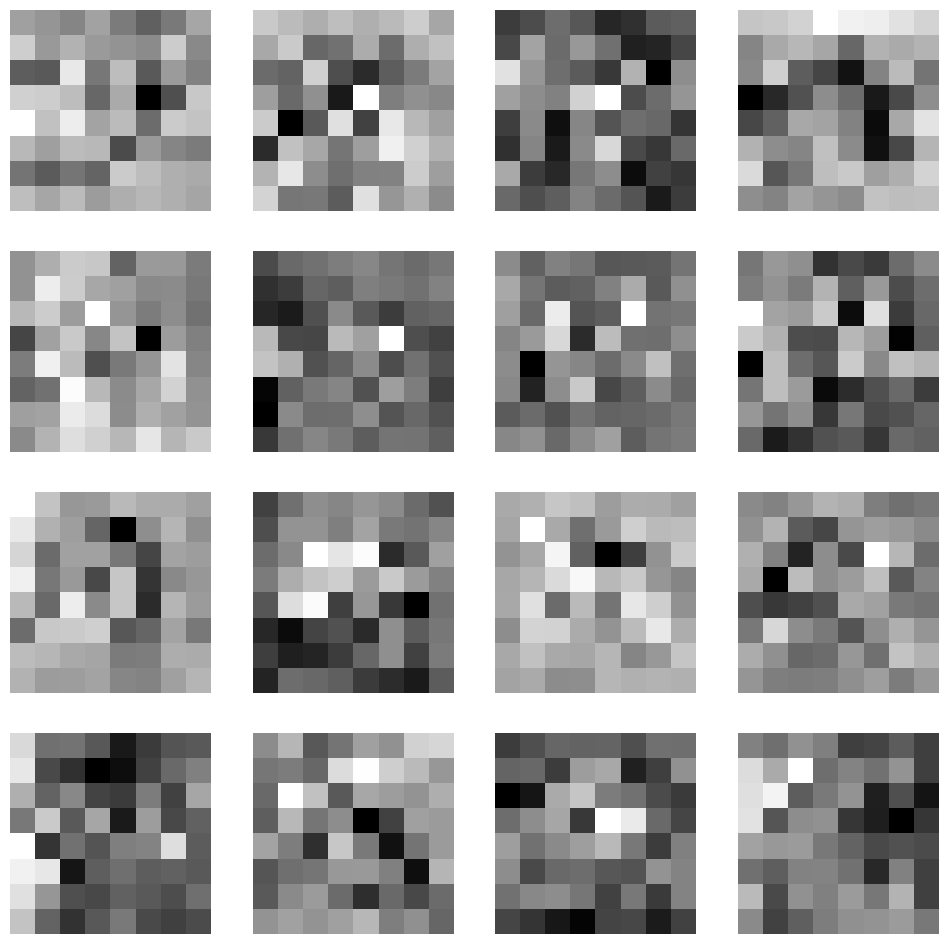


Layer Number:  3
Total Number of Features in the Layer:  512
Selected Feature Indexes:  [  2 375 128 305 485 469 293  14 300   6 243 430  31 318 139  54]


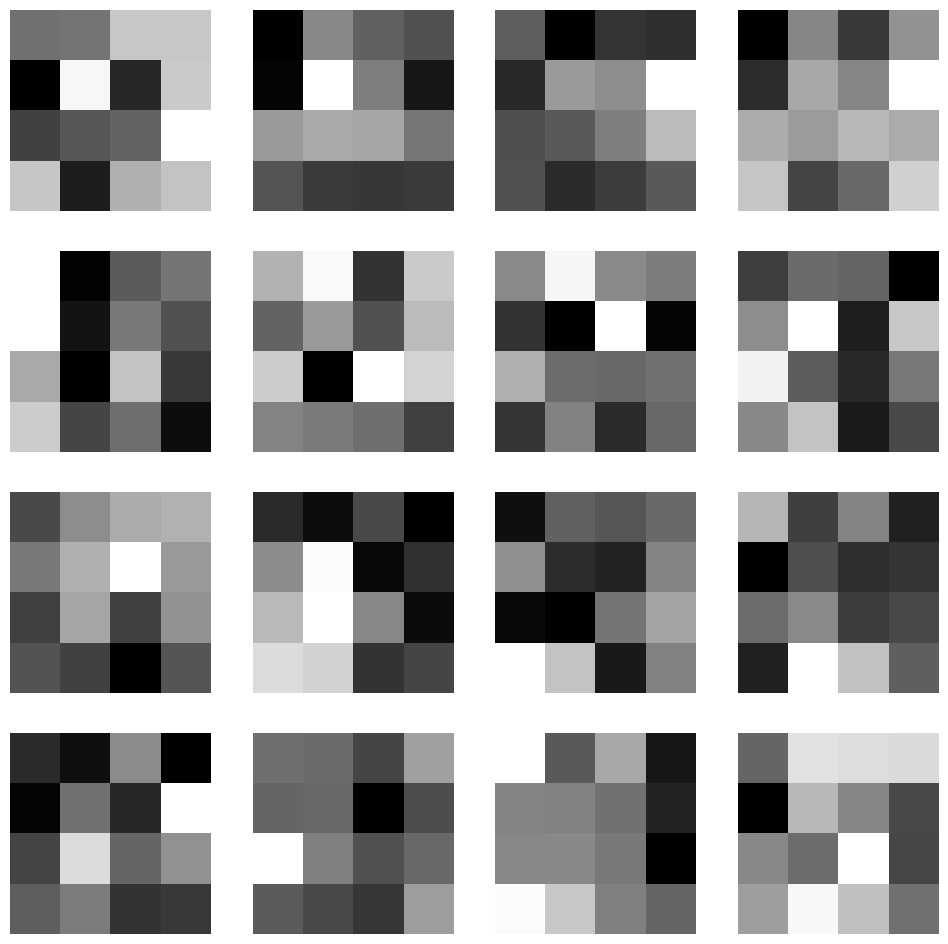

Generator Layers: 

Layer Number:  0
Total Number of Features in the Layer:  1024
Selected Feature Indexes:  [523 524 572 723 172 176 197 743 467 973  66 913 308 546 977 755]


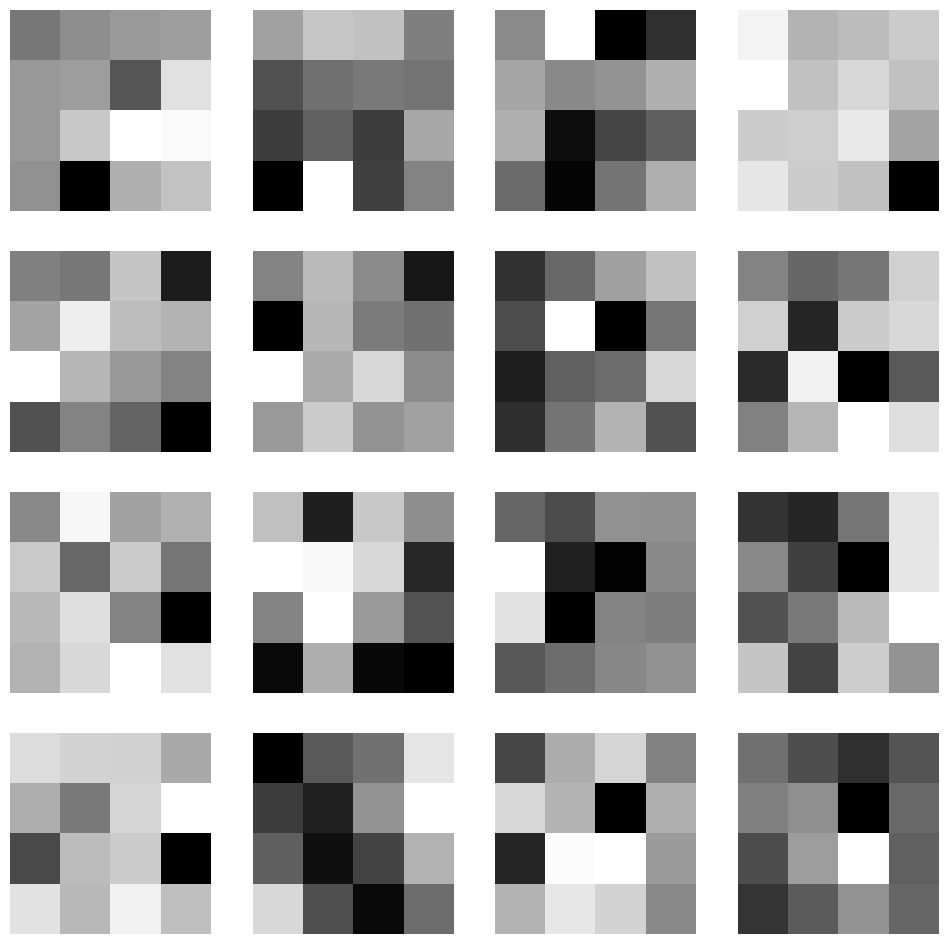


Layer Number:  1
Total Number of Features in the Layer:  512
Selected Feature Indexes:  [  0 433 228   5 102 149 348 124 258  18 239 129 456 220 206 210]


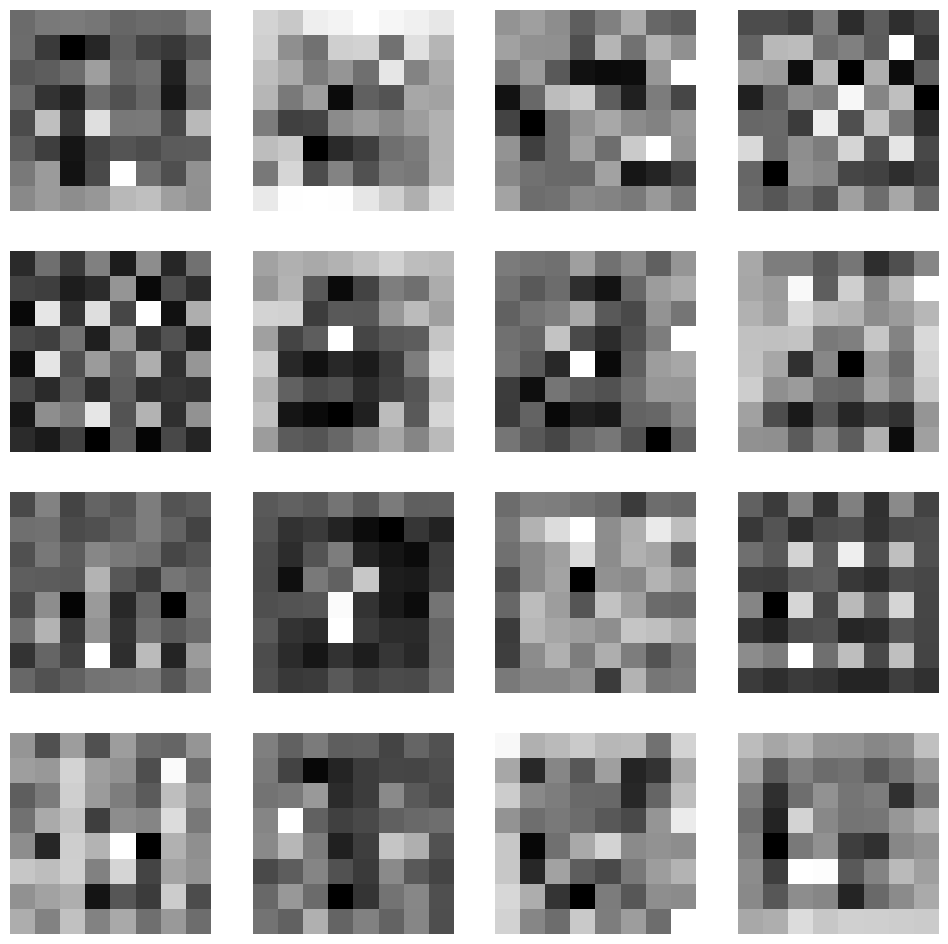


Layer Number:  2
Total Number of Features in the Layer:  256
Selected Feature Indexes:  [107 187  10 235 130 243 213 146 190 120 232 218 190 164 237 193]


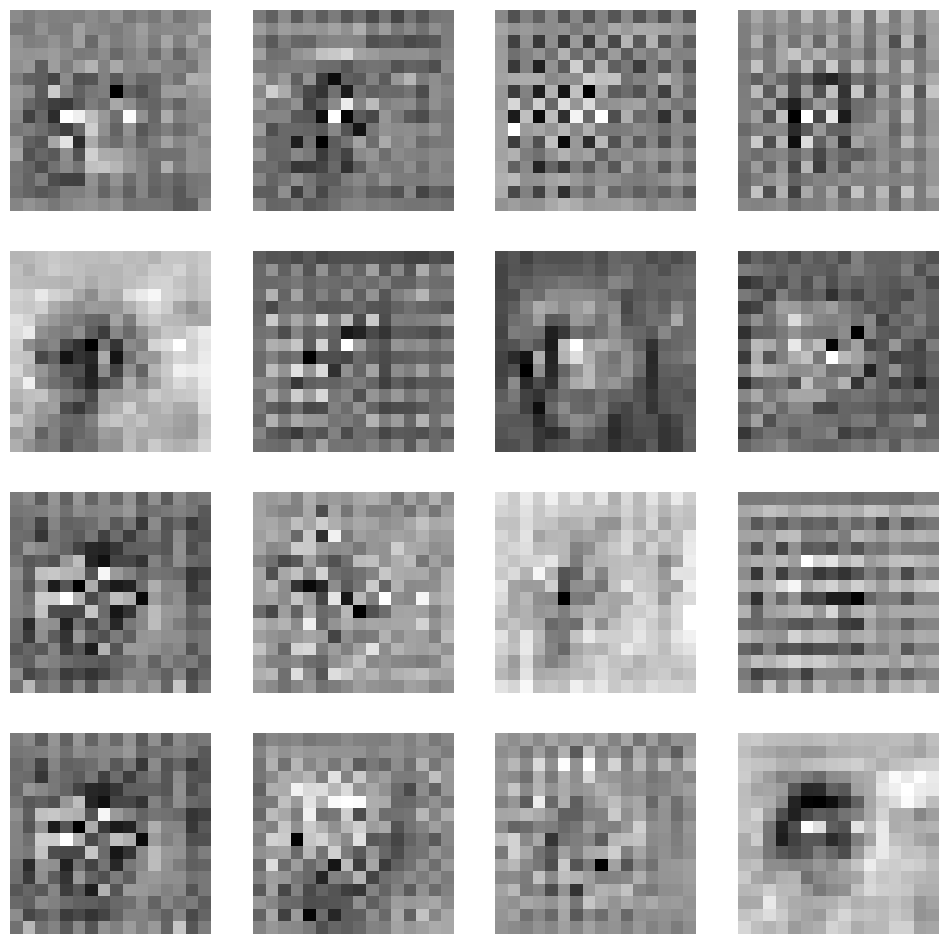


Layer Number:  3
Total Number of Features in the Layer:  128
Selected Feature Indexes:  [120 105  80  87  51  70 116  66  74 124  15  25  70  60  21  87]


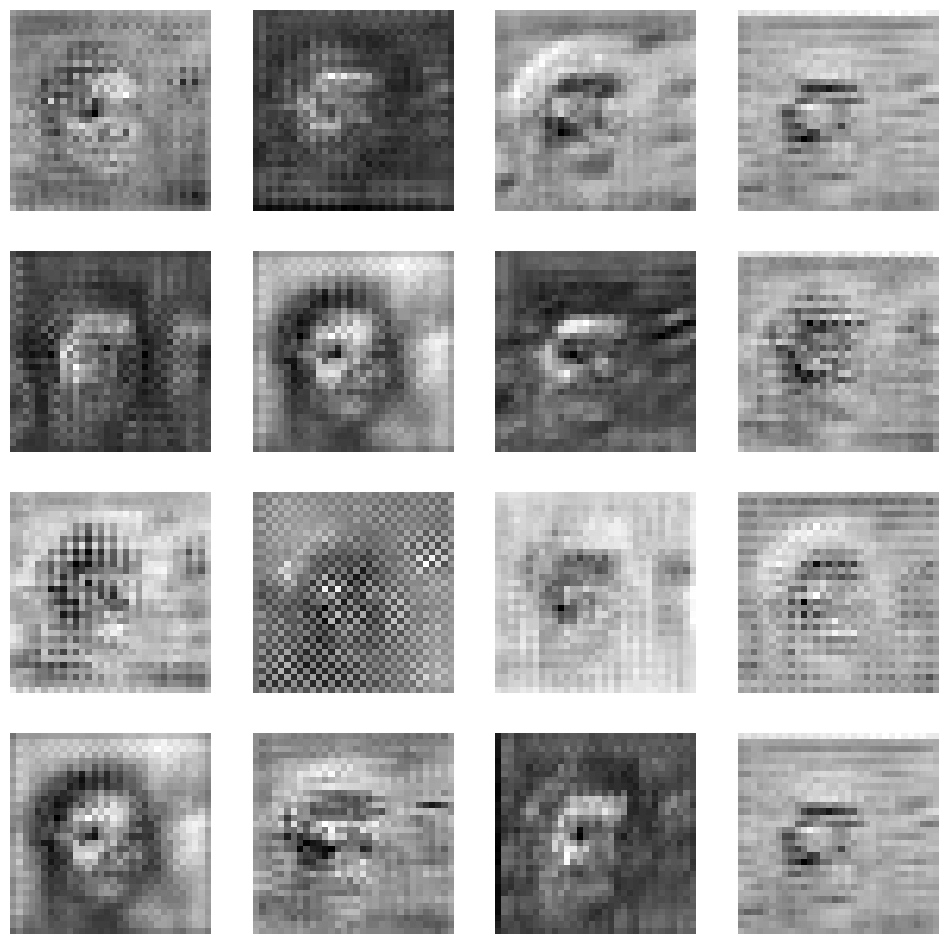

In [18]:
def plot_features(features, layer_num, num_filters=16):
    layer_features = features[layer_num].detach().cpu()
    
    feature_picks= np.random.randint(0,layer_features.shape[1], size=16)
    print("\nLayer Number: ",layer_num)
    print("Total Number of Features in the Layer: ",layer_features.shape[1])
    print("Selected Feature Indexes: ", feature_picks)
    # Plot the first 'num_filters' feature maps
    fig, axes = plt.subplots(4,4, figsize=(12, 12))
    for i in range(16):
        ax= axes[i//4,i%4]
        if i < layer_features.shape[1]:  # Ensure we don't exceed the number of filters
            ax.imshow(layer_features[0, feature_picks[i], :, :], cmap='gray')
        ax.axis('off')
    plt.show()

print("Discriminator Layers: ")
for ln in range(4):
    plot_features(features_disc, layer_num=ln)

print("Generator Layers: ")
for ln in range(4):
    plot_features(features_gen, layer_num=ln)


In [55]:
isinstance(discrim.disc[3], nn.Sequential)

True